<a href="https://colab.research.google.com/github/nada-086/AutoEDA/blob/main/Automated_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sqlite3 as sql
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, f_regression, SelectKBest
from sklearn.decomposition import PCA

In [2]:
def read_data():
  while True:
    file_path = input('Enter The File Path: ')
    if os.path.exists(file_path):
      try:
        file_type = file_path.split('.')[1]
      except:
        print("Error, Invalid File Name.")
        continue

      # Reading CSV Files
      data = []
      if file_type == 'csv':
        data = pd.read_csv(file_path)
      # Reading Excel Files
      elif file_type == 'xlsx':
        data = pd.read_excel(file_path)
      # Reading Data Files
      elif file_type == 'sqlite':
        data = read_sqlite_file(file_path)
      else:
        print('Error: Unsupported File Type')

      # Check The Validity of Data
      if data.empty:
        print("Error, Empty File.")
      else:
        break
    else:
      print("Error: Invalid File Path. Please, Try Again.")

  return data.dropna()

In [3]:
def read_sqlite_file(file_path):
    # Starting Connection and Reading The Tables Names
    conn = sql.connect(file_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = [row[0] for row in cursor.fetchall()]
    if not table_names:
        return pd.DataFrame()
    table_name = table_names[0]

    # Getting All The Data In The Table
    cursor.execute(f"SELECT * FROM {table_name}")
    data = cursor.fetchall()
    if not data:
        return pd.DataFrame()
    columns = [column[0] for column in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    cursor.close()
    conn.close()
    return df

In [4]:
def preprocessing_data(data):
  # Encode Categorical Features
  label_encoder = LabelEncoder()
  categorical_columns = data.select_dtypes(include='object').columns
  for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

  # Scale Numerical Features
  scaler = StandardScaler()
  numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
  data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

  return data

In [5]:
def feature_selection(data, target):
  selector = ''
  if data[target].dtype == 'object':
    selector = SelectKBest(score_func=mutual_info_classif, k=2)
  else:
    selector = SelectKBest(score_func=f_regression, k=2)
  X_new = selector.fit_transform(data.iloc[:, :-1], data[target])

  # Get the selected feature names
  selected_indices = selector.get_support()
  selected_feature_names = data.drop(columns=[target]).columns[selected_indices]
  return selected_feature_names

In [6]:
def dimensionality_reduction(data):
  pca = PCA(n_components=2)
  new_data = pca.fit_transform(data)
  return pd.DataFrame(new_data)

In [7]:
def plot_reduced(data, features):
  if 'float' in str(data[features[0]].dtype) and 'float' in str(data[features[1]].dtype):
    # Scatter Plot
    fig = px.scatter(data, x=features[0], y=features[1], title=f'Scatter Plot {features[0]} vs {features[1]}')
    fig.show()
  elif 'float' in str(data[features[0]].dtype):
    # Box Plot
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=data, y=features[0], x=features[1])
    plt.title(f'Box Plot of {features[1]} by {features[0]}')
    plt.xticks(rotation=45)
    plt.show()
  elif 'float' in str(data[features[1]].dtype):
    # Box Plot
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=data, y=features[1], x=features[0])
    plt.title(f'Box Plot of {features[0]} by {features[1]}')
    plt.xticks(rotation=45)
    plt.show()
  else:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=features[0], hue=features[1])
    plt.xlabel('Category 1')
    plt.ylabel('Count')
    plt.title('Stacked Bar Plot of Category 1 by Category 2')
    plt.legend(title='Category 2')
    plt.show()

In [8]:
def plot_column(data, column_name, column_type):
  if 'float' in str(column_type):
    plt.figure(figsize=(5, 3))
    sns.histplot(data=data, x=column_name, edgecolor='white')
    plt.title(f'Histogram of {column_name}')
    plt.show()
  else:
    # Bie Chart
    plt.figure(figsize=(5, 3))
    value_counts = data[column_name].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart of {column_name}')
    plt.axis('equal')
    plt.show()

In [9]:
def main():
  # Reading Data
  data = read_data()
  columns = list(zip(data.columns, data.dtypes))
  processed_data = preprocessing_data(data)

  # Feature Selection
  features = feature_selection(processed_data, columns[-1][0])
  plot_reduced(data, features)

  # Dimensionality Reduction
  reduced_data = dimensionality_reduction(data)
  # plot_reduced(reduced_data)

  print('------------------------------------------------------')
  for column, column_type in columns:
    print(f'{column} -> {column_type}')
    plot_column(data, column, column_type)
  print('------------------------------------------------------')

Enter The File Path: /content/winequality-red.csv


------------------------------------------------------
fixed acidity -> float64


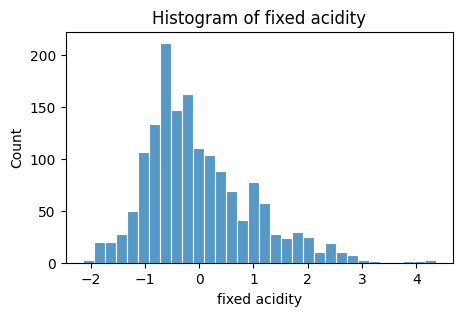

volatile acidity -> float64


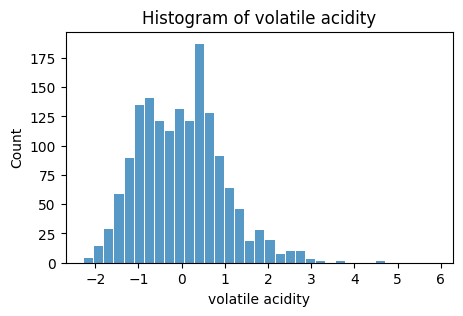

citric acid -> float64


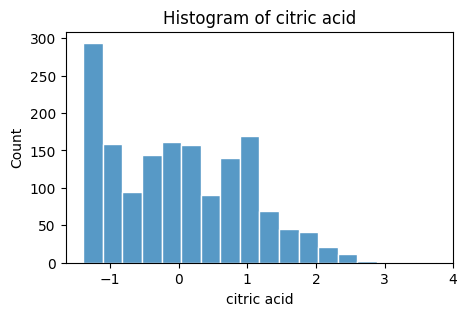

residual sugar -> float64


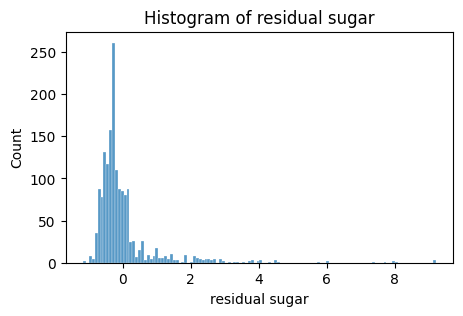

chlorides -> float64


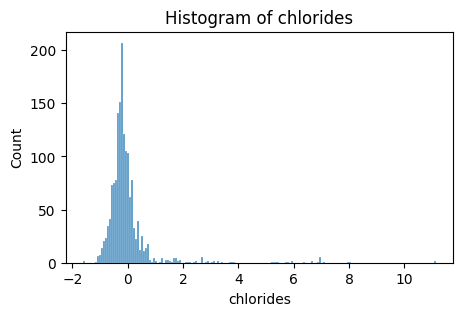

free sulfur dioxide -> float64


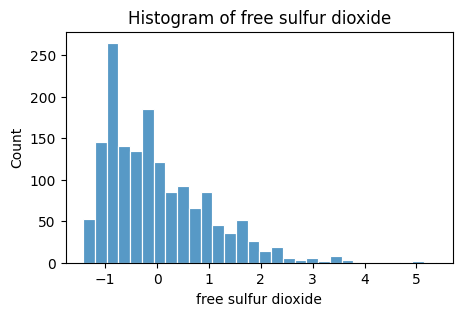

total sulfur dioxide -> float64


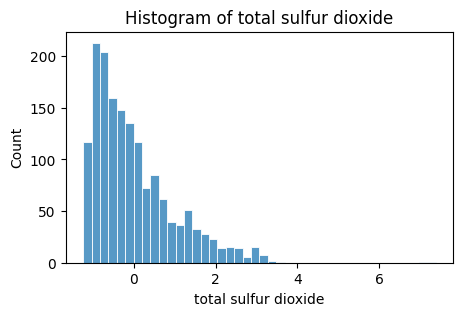

density -> float64


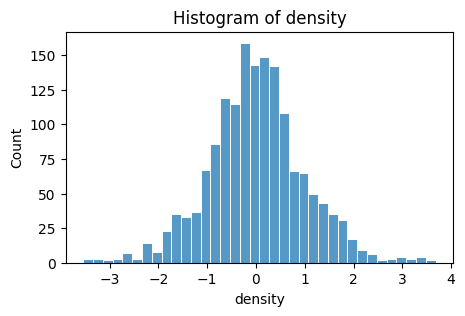

pH -> float64


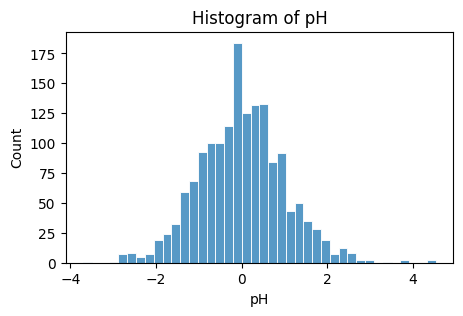

sulphates -> float64


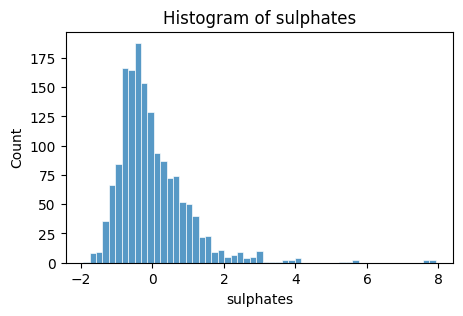

alcohol -> float64


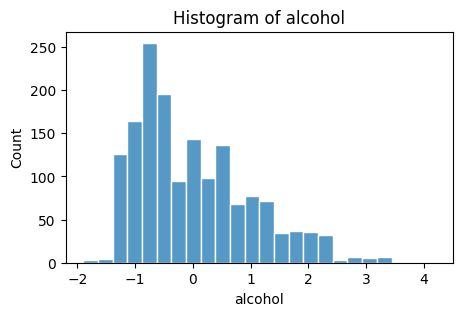

quality -> int64


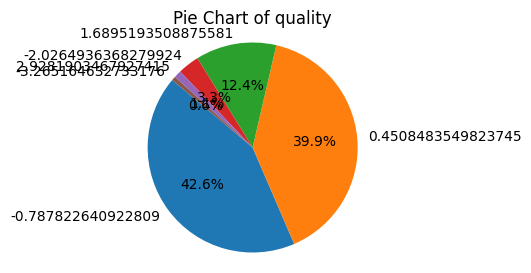

------------------------------------------------------


In [12]:
main()